<a href="https://colab.research.google.com/github/aeyjeyaryan/Deep-Learning/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow numpy matplotlib --q

Epoch 1/100, D Loss: 0.5518, G Loss: 1.8200
Epoch 2/100, D Loss: 0.7432, G Loss: 1.5257
Epoch 3/100, D Loss: 0.7199, G Loss: 1.5958
Epoch 4/100, D Loss: 0.7055, G Loss: 1.6734
Epoch 5/100, D Loss: 0.7090, G Loss: 1.7246
Epoch 6/100, D Loss: 0.6901, G Loss: 1.7688
Epoch 7/100, D Loss: 0.6942, G Loss: 1.8311
Epoch 8/100, D Loss: 0.6570, G Loss: 1.8707
Epoch 9/100, D Loss: 0.6441, G Loss: 1.9314
Epoch 10/100, D Loss: 0.6519, G Loss: 1.9768
Epoch 11/100, D Loss: 0.6542, G Loss: 2.0064
Epoch 12/100, D Loss: 0.5945, G Loss: 2.0524
Epoch 13/100, D Loss: 0.6659, G Loss: 2.0729
Epoch 14/100, D Loss: 0.6233, G Loss: 2.1011
Epoch 15/100, D Loss: 0.6137, G Loss: 2.1284
Epoch 16/100, D Loss: 0.6180, G Loss: 2.1406
Epoch 17/100, D Loss: 0.6038, G Loss: 2.1625
Epoch 18/100, D Loss: 0.5882, G Loss: 2.2095
Epoch 19/100, D Loss: 0.5564, G Loss: 2.2370
Epoch 20/100, D Loss: 0.5679, G Loss: 2.2754
Epoch 21/100, D Loss: 0.5929, G Loss: 2.2660
Epoch 22/100, D Loss: 0.5789, G Loss: 2.2889
Epoch 23/100, D Los

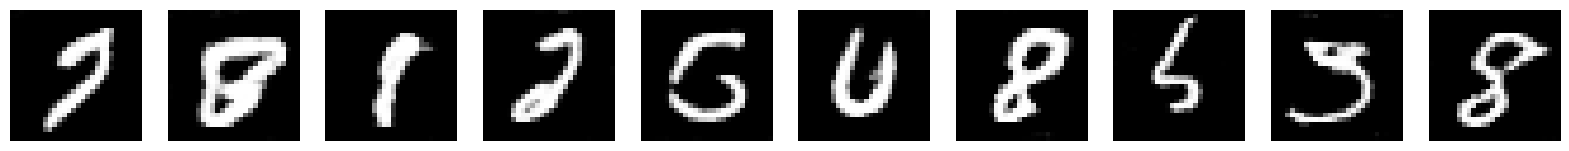

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import os

os.makedirs('mnist_samples', exist_ok=True)

# Disable eager execution if you want to continue using TF1.x style code
# tf.compat.v1.disable_eager_execution()

# Or better, use TF2 with Keras - which is what we'll do here

def load_data():
    (x_train, _), (_, _) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5
    # Reshaping
    x_train = x_train.reshape(-1, 28, 28, 1)
    return x_train

# Hyperparameters for the base nets
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.0002
BETA_1 = 0.5  # Adam optimizer will use this as paramaeter

NOISE_DIM = 100  # Noise dimension
IMAGE_SIZE = 28
IMAGE_CHANNELS = 1

#The generator
def make_generator_model():
    model = tf.keras.Sequential()

    # First fully connected layer, reshaped to 7x7x128
    model.add(tf.keras.layers.Dense(7*7*128, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Reshape((7, 7, 128)))

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

# The Discriminator
def make_discriminator_model():
    model = tf.keras.Sequential()

    # First conv layer
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    # second conv
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

    # Output layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

# loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator's loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Generator's loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=BETA_1)
discriminator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=BETA_1)

# Creating the generator and discrimninator
# note to self: Will use the same function in other experimentation
generator = make_generator_model()
discriminator = make_discriminator_model()

# Generate noise samples
def generate_noise(num_samples):
    return tf.random.normal([num_samples, NOISE_DIM])

# Save generated images
def save_images(epoch, generator, examples=10):
    noise = generate_noise(examples)
    generated_images = generator(noise, training=False)

    generated_images = (generated_images * 0.5) + 0.5

    fig, axs = plt.subplots(1, examples, figsize=(examples * 2, 2))
    for i in range(examples):
        if examples > 1:
            axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
            axs[i].axis('off')
        else:
            axs.imshow(generated_images[i, :, :, 0], cmap='gray')
            axs.axis('off')
    plt.savefig(f'mnist_samples/epoch_{epoch:03d}.png', bbox_inches='tight')
    plt.close(fig)

# Define the training step
@tf.function
def train_step(images):
    noise = generate_noise(BATCH_SIZE)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images
        generated_images = generator(noise, training=True)

        # Get discriminator outputs for real and fake images
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Calculate losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# take number input
def generate_user_images(generator, num_images):
    noise = generate_noise(num_images)
    generated_images = generator(noise, training=False)
    generated_images = (generated_images * 0.5) + 0.5  # Rescale to [0, 1]

    fig, axs = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    if num_images == 1:
        axs.imshow(generated_images[0, :, :, 0], cmap='gray')
        axs.axis('off')
    else:
        for i in range(num_images):
            axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
            axs[i].axis('off')
    plt.show()

def train(dataset, epochs):
    for epoch in range(epochs):
        epoch_gen_loss = 0
        epoch_disc_loss = 0
        batches = 0

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            epoch_gen_loss += gen_loss
            epoch_disc_loss += disc_loss
            batches += 1

        epoch_gen_loss /= batches
        epoch_disc_loss /= batches

        print(f'Epoch {epoch+1}/{epochs}, D Loss: {epoch_disc_loss:.4f}, G Loss: {epoch_gen_loss:.4f}')

        # Save sample images every 10 epochs
        if epoch % 10 == 0 or epoch == epochs - 1:
            save_images(epoch, generator)

    print('Training Finished!')

# Main function
def main():
    train_images = load_data()
    train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(BATCH_SIZE)

    train(train_dataset, EPOCHS) #gan trains here

    while True:
        try:
            num_images = int(input("\nEnter the number of images to generate (1-10, or 0 to exit): "))
            if num_images == 0:
                break
            if 1 <= num_images <= 10:
                generate_user_images(generator, num_images)
            else:
                print("Please enter a number between 1 and 10")
        except ValueError:
            print("Please enter a valid number")

if __name__ == "__main__":
    main()